In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# DeepLab 모델. 구글에서 제공하는 모델 구조 그대로 -> DeepLabModel 클래스

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

print('done')

done


In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab/human_segmentation/models
model loaded successfully!


(720, 1280, 3)


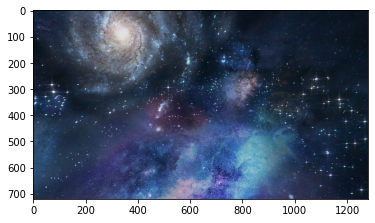

In [4]:
# 배경이 될 사진 불러와서 크기 확인

img_path_galaxy = '/content/drive/MyDrive/Colab/human_segmentation/images/galaxy.jpg'
galaxy_orig = cv2.imread(img_path_galaxy) 
print (galaxy_orig.shape)

plt.imshow(cv2.cvtColor(galaxy_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1530, 1242, 3)


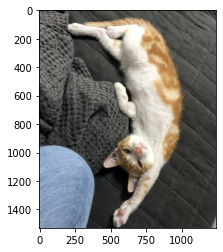

In [5]:
# 고양이 사진 불러와서 크기 확인

img_path_cat = '/content/drive/MyDrive/Colab/human_segmentation/images/cat.jpg'
cat_orig = cv2.imread(img_path_cat) 
print (cat_orig.shape)

plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1242, 1530, 3)


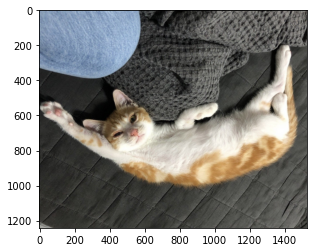

In [6]:
# 원본 이미지를 시계방향으로 90도 만큼 회전
cat_orig = cv2.rotate(cat_orig, cv2.ROTATE_90_CLOCKWISE)
print (cat_orig.shape)
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

(720, 886, 3)


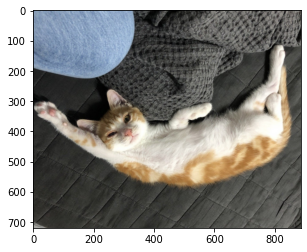

In [7]:
# 배경 이미지와 세로 길이 맞춰주기

ratio = cat_orig.shape[1]/cat_orig.shape[0]
height = 720
width = int(height*ratio)

cat_orig = cv2.resize(cat_orig, (width, height), interpolation=cv2.INTER_AREA)
print (cat_orig.shape)
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
cat_resized, cat_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, cat_map.max())

(720, 886, 3) (416, 513, 3) 8


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

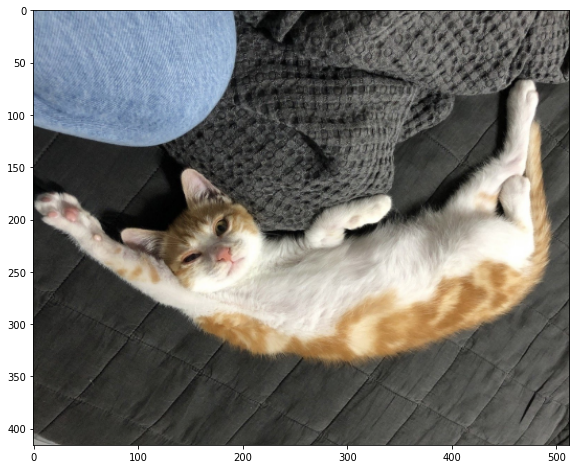

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(cat_resized, cv2.COLOR_BGR2RGB))
plt.show()

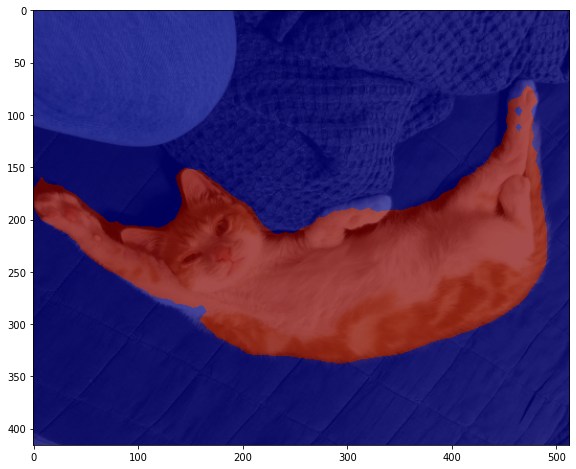

In [11]:
cat_show = cat_resized.copy() # 리사이즈 이미지 저장
cat_map = np.where(cat_map == 8, 8, 0) # 예측 중 픽셀값이 8 인 cat만 추출
cat_mask = cat_map * (255/cat_map.max()) # 255 normalization
# cat_max.max() = 8 이므로 cat_map / cat_map.max()는 0과 1로 이루어진 행렬
# 255를 곱했으므로 차인 부분은 255, 차가 아닌 부분은 0인 마스크가 만들어진다
cat_mask = cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.3, color_mask, 0.7, 0.0)

# 시맨틱 세그멘테이션 : 차와 차가 아닌걸 다른 색으로 구분
fig = plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
cat_orig.shape

(720, 886, 3)

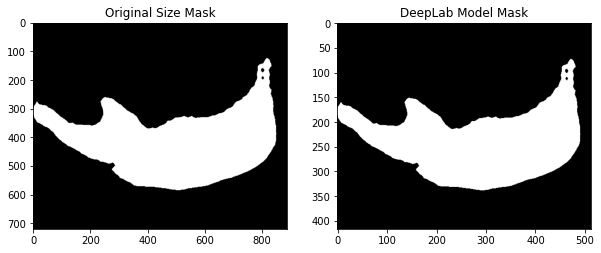

In [13]:
# 고양이만 보이는 마스크를 원본 사이즈로 리사이징
cat_mask_up = cv2.resize(cat_mask, (width, height), interpolation=cv2.INTER_LINEAR)
#cat_orig = cv2.resize(cat_orig, (width, height), interpolation=cv2.INTER_AREA)

_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 8))

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

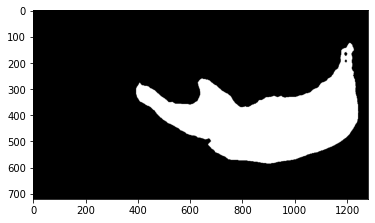

In [14]:
# 마스크를 배경과 같은 사이즈로 만들기 위해 왼쪽에 검은 테두리 넣어주기

pad = galaxy_orig.shape[1] - cat_orig.shape[1]

padding_mask = cv2.copyMakeBorder(cat_mask_up,
                                  top = 0,
                                  bottom = 0,
                                  left = pad,
                                  right = 0,
                                  borderType = cv2.BORDER_CONSTANT,
                                  value=[0,0,0])

plt.imshow(padding_mask, cmap=plt.cm.binary_r)
plt.show()

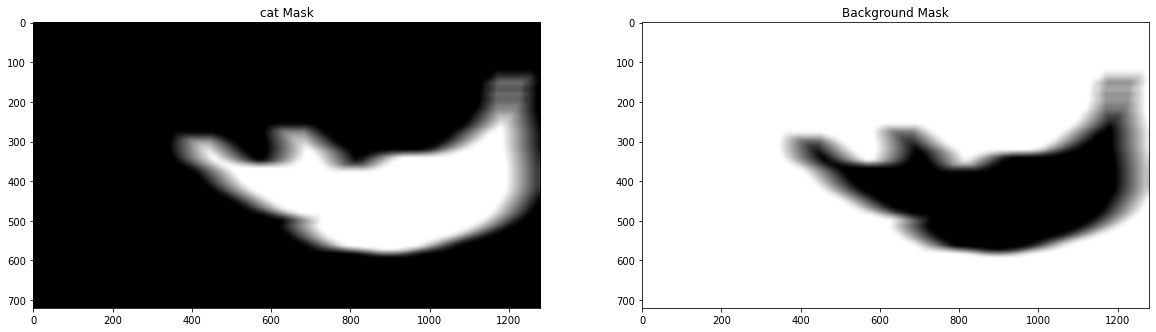

In [36]:
# 고양이만 보이는 마스크를 원본 이미지와 같은 채널로 변환
padding_mask_3C = np.repeat(np.expand_dims(padding_mask, axis=2), 3, axis=2).astype(np.uint8)
# 한 픽셀에 하나의 숫자 0, 255만 나타나있는 padding_mask 매트릭스를
# 한 픽셀에 [0,0,0], [255,255,255]인 텐서로 바꿔주는 역할

# 고양이만 보이는 마스크 블러 처리
padding_Bmask = (cv2.blur(padding_mask_3C, (100, 20))/255).astype(np.float32)
# blur 함수로 픽셀들의 값이 [0,225] 사이의 값으로 부드럽게 바뀌고
# 255로 나눠주었으므로 [0,1] 사이의 값이 됨

# 마스크를 리버스해서 배경만 보이는 마스크 만들기
bg_Bmask = 1 - padding_Bmask
# 값들이 float라서 노드처럼 bitwise 연산을 할 수는 없고
# 대신 1에서 마스크의 값을 빼주면 완벽하게 뒤집힌 마스크를 얻을 수 있음

fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(1,2,1)
plt.imshow(padding_Bmask, cmap=plt.cm.binary_r) # 고양이만 보이는 블러마스크
ax.set_title('cat Mask')

ax = plt.subplot(1,2,2)
plt.imshow(bg_Bmask, cmap=plt.cm.binary_r) # 배경만 보이는 블러 마스크 
ax.set_title('Background Mask')

plt.show()

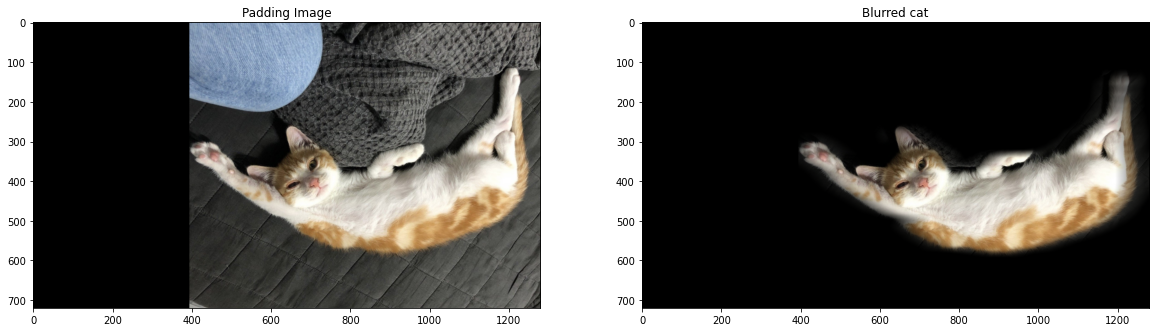

In [37]:
# 고양이만 보이는 마스크 * 원본이미지 로
# 경계면이 블러 처리된 고양이 얻기

# 고양이를 배경과 같은 사이즈로 만들기 위해 왼쪽에 검은 테두리 넣어주기

padding_cat = cv2.copyMakeBorder(cat_orig,
                                 top = 0,
                                 bottom = 0,
                                 left = pad,
                                 right = 0,
                                 borderType = cv2.BORDER_CONSTANT,
                                 value=[0,0,0])
# 곱연산
cat_image_Hblur = padding_Bmask*padding_cat.astype(np.float32)
# 이제 두 텐서를 원소별 곱연산 해주면, 경계는 원본의 픽셀값이 0.x 배로 감소해서 연해짐
# 고양이부분은 1 이므로 원본 이미지의 픽셀값이 그대로이므로 흐려지지 않음


fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(padding_cat, cv2.COLOR_BGR2RGB))
ax.set_title('Padding Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cat_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred cat')

plt.show()

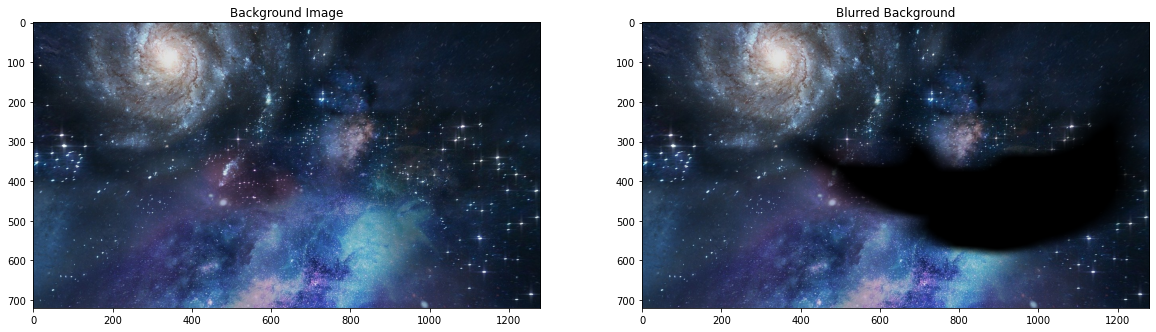

In [38]:
# 배경만 보이는 마스크 * 배경이미지 로
# 고양이가 들어갈 자리가 비어있는 배경 얻기

bg_image_Hblur = bg_Bmask*galaxy_orig.astype(np.float32)

fig = plt.figure(figsize=(20, 15)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(galaxy_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Background Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(bg_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Background')

plt.show()

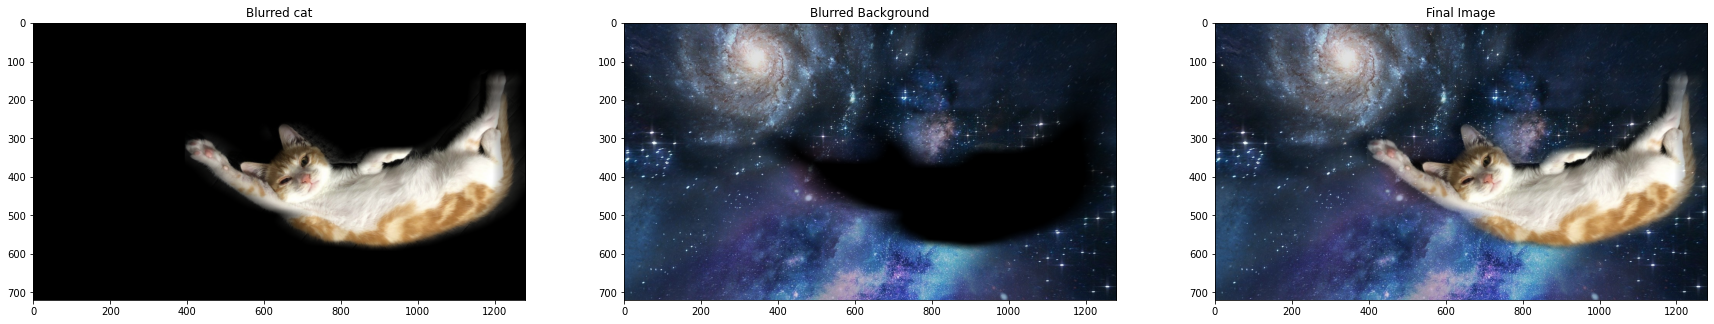

In [39]:
# 두 이미지를 합해서 최종 이미지 획득

final_image = (cat_image_Hblur+bg_image_Hblur).astype(np.uint8)

fig = plt.figure(figsize=(30, 20)) 

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(cat_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred cat')

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(bg_image_Hblur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Blurred Background')

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
ax.set_title('Final Image')

plt.show()

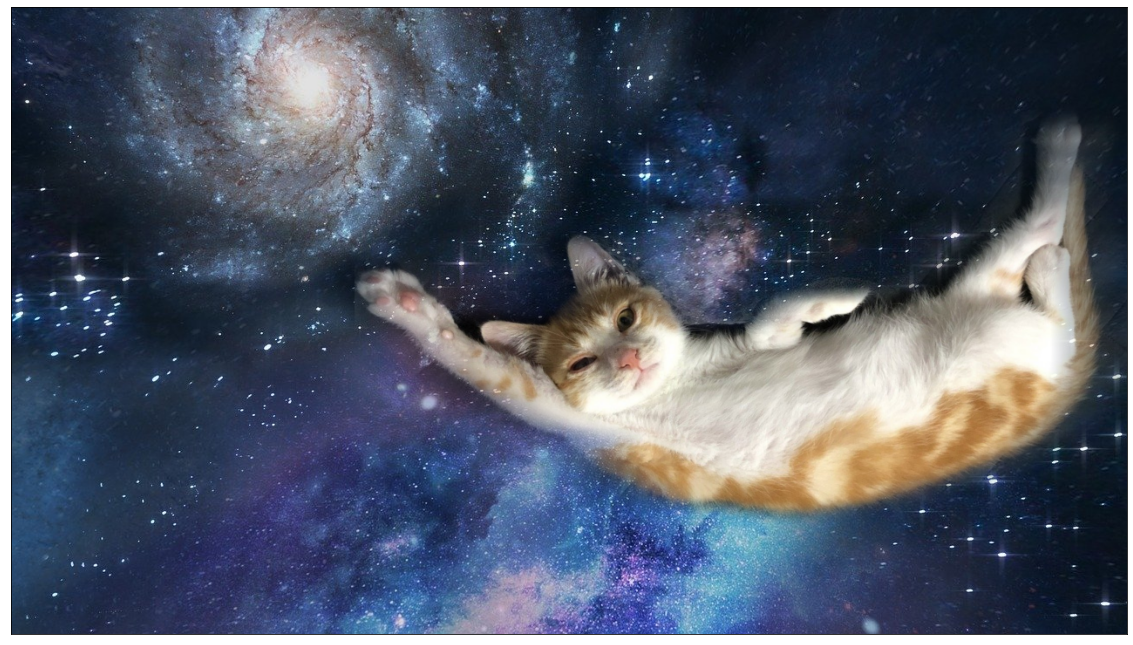

In [40]:
fig = plt.figure(figsize=(20, 15)) 

plt.imshow(cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
plt.xticks([]) #x좌표 눈금 제거
plt.yticks([]) #y좌표 눈금 제거
plt.show()